In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

Let us consider a dataset $\mathcal D = \{ x_i, y_i \}_{i=1}^n$, where $y_i \in \{0, 1\}$ is the binary label, $x_i \in \mathbb R^d$ is the feature real-valued vector. Total number of instances is $n$.

In [3]:
iris = load_iris()

X = iris.data[:100]
y = iris.target[:100]

# Classes
# -- Setosa (0)
# -- Versicolor (1)
# Our binary classifier identifies if its iris versicolor or not.

print(f"Number of observations (n): {X.shape[0]}")
print(f"Feature dimensions (d): {X.shape[1]}")
print(f"Classes: {np.unique(y)}")

Number of observations (n): 100
Feature dimensions (d): 4
Classes: [0 1]


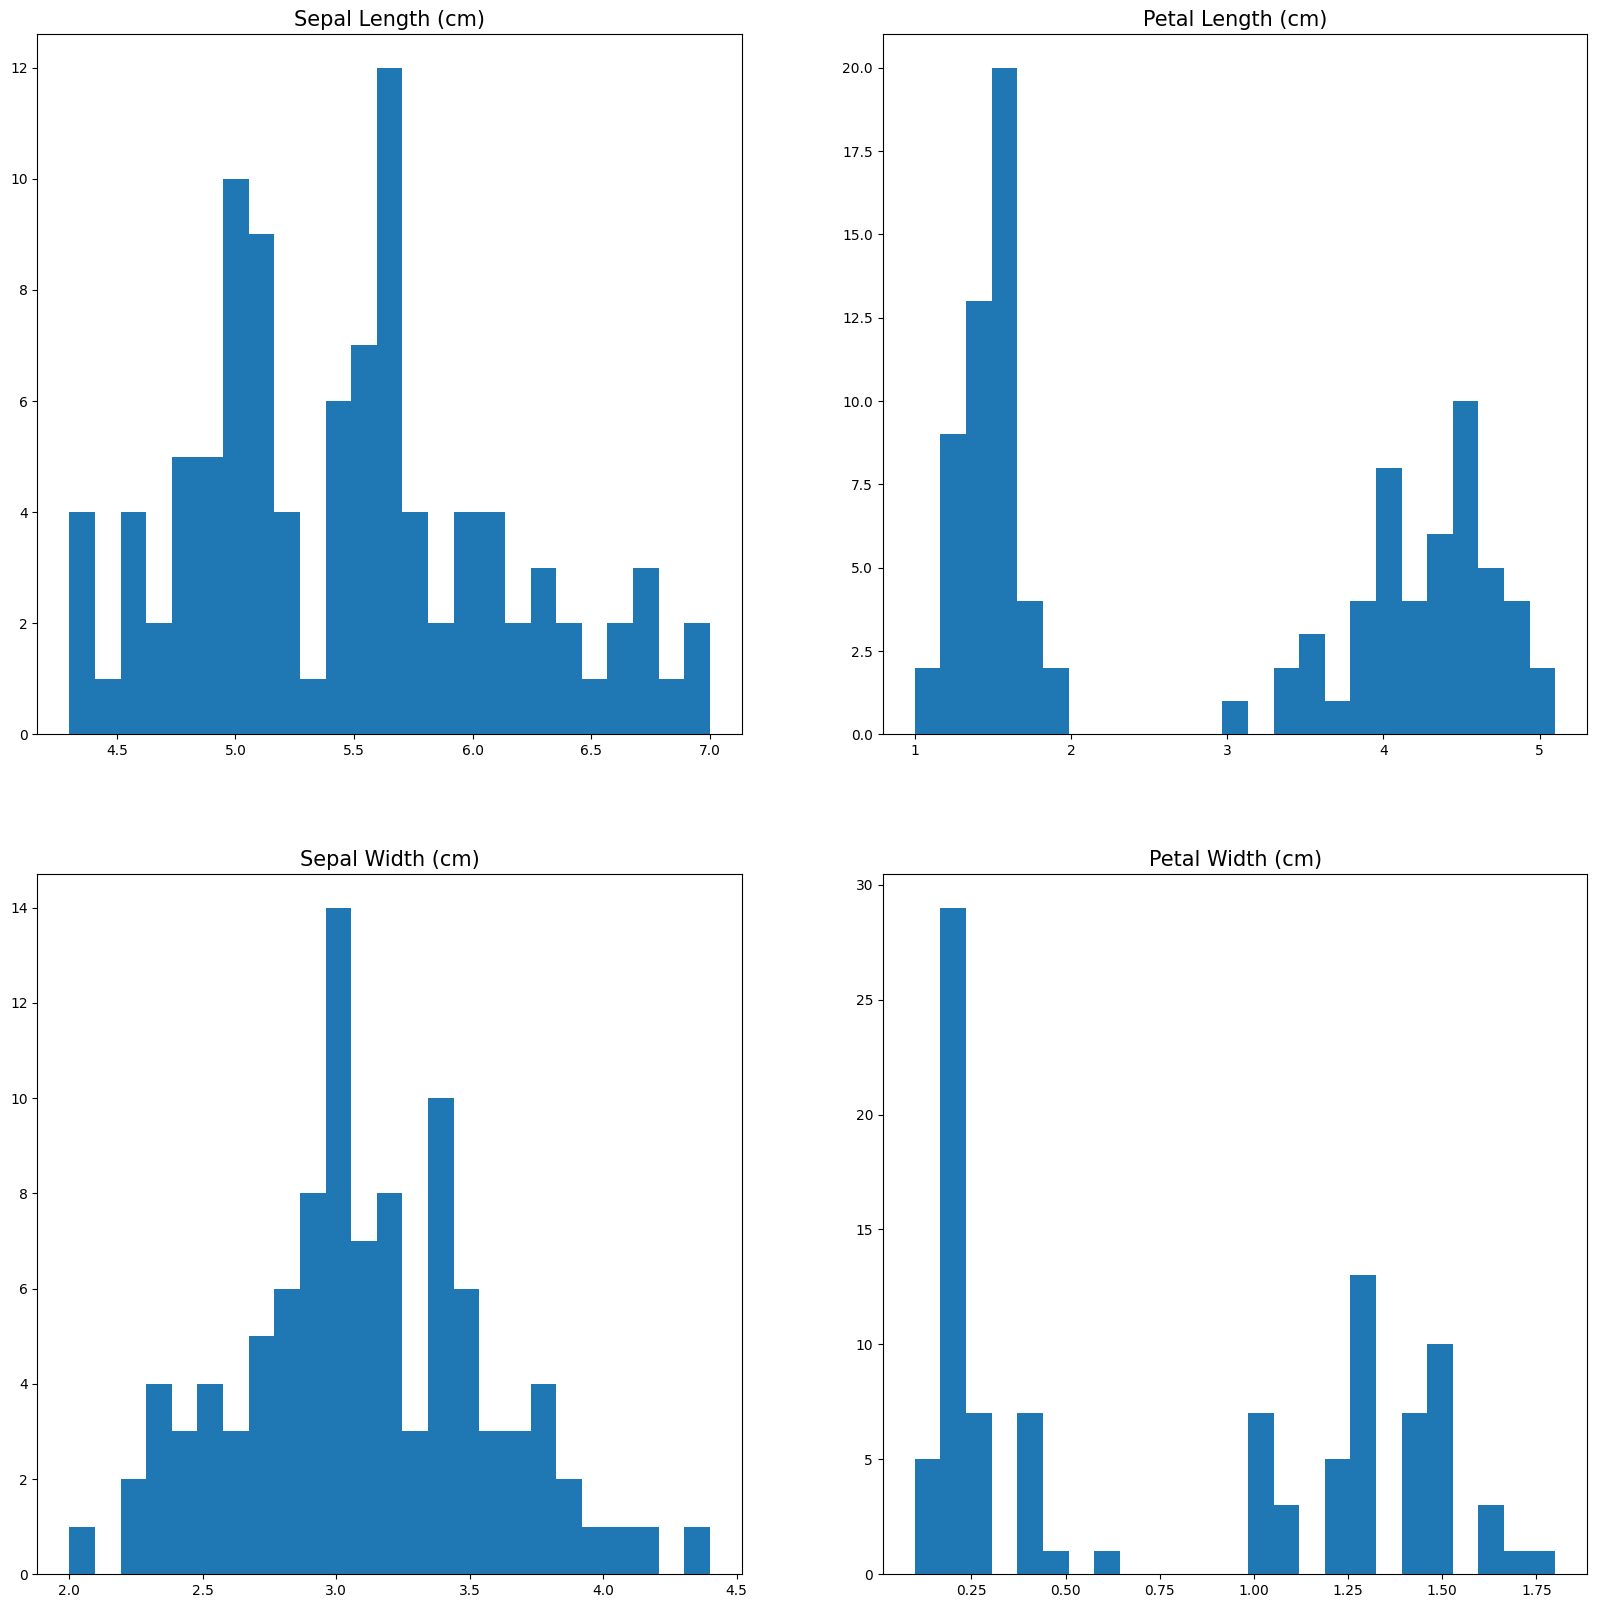

In [5]:
features = [
    "Sepal Length (cm)",
    "Sepal Width (cm)",
    "Petal Length (cm)",
    "Petal Width (cm)",
]

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

axs[0, 0].hist(X[:, 0], bins=25)
axs[0, 0].set_title(features[0], fontsize=15)

axs[1, 0].hist(X[:, 1], bins=25)
axs[1, 0].set_title(features[1], fontsize=15)

axs[0, 1].hist(X[:, 2], bins=25)
axs[0, 1].set_title(features[2], fontsize=15)

axs[1, 1].hist(X[:, 3], bins=25)
axs[1, 1].set_title(features[3], fontsize=15)

plt.show()

Let us discretize the continuous values that $X$ takes into bins for each feature, thus turning the variables to categorical, which is often the case for datasets in practice. We stup the following categories based on quantiles:

  * Sepal Length (cm) $\{ 0, 1, 2, 3, 4\}$
  * Sepal Width (cm) $\{ 0, 1, 2, 3, 4\}$
  * Petal Length (cm) \{ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}
  * Petal Width (cm) \{ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11\}

In [6]:
from sklearn.preprocessing import KBinsDiscretizer

In [10]:
descretizer_0 = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
X[:, 0] = descretizer_0.fit_transform(X[:, 0].reshape(-1, 1)).reshape(-1)

descretizer_1 = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
X[:, 1] = descretizer_1.fit_transform(X[:, 1].reshape(-1, 1)).reshape(-1)

descretizer_2 = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
X[:, 2] = descretizer_2.fit_transform(X[:, 2].reshape(-1, 1)).reshape(-1)

descretizer_3 = KBinsDiscretizer(n_bins=12, encode="ordinal", strategy="quantile")
X[:, 3] = descretizer_3.fit_transform(X[:, 3].reshape(-1, 1)).reshape(-1)

/home/avilay/.venvs/ai/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/avilay/.venvs/ai/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


We randomly shuffle and split the data into training and validation datasets.

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.35, random_state=12, shuffle=True
)

# Check the distribution of classes in training and validation sets
print("Fraction of 1s in training: {:.4f}".format(sum(y_train) / len(y_train)))
print("Fraction of 1s in validation: {:.4f}".format(sum(y_val) / len(y_val)))

Fraction of 1s in training: 0.5077
Fraction of 1s in validation: 0.4857


A binary classifier $f$ maps each value $x$ to a probability of belonging to the class $y = 1$. We denote $p_i = f(x_i) \forall \{ 1, \cdots, n\}$ as the probability outputed by our trained model that observation $x_i$ has been labeled as $y_i$. 

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

mlp = MLPClassifier(hidden_layer_sizes=10, batch_size=16, max_iter=40, random_state=12)

# Normalize the input
scaler = MinMaxScaler()
scaled = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Train model
mlp.fit(X_train, y_train)

/home/avilay/.venvs/ai/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=16, hidden_layer_sizes=10, max_iter=40,
              random_state=12)

We evaluate our pre-cal (before calibration) trained model performance across ROC AUC and Normalized Cross Entropy (NE).

$$
ne = \frac{ll(y, \hat y)}{- y_+ log(y_+) - (1 - y_+)log(1 - y_+)}
$$

In [14]:
from sklearn.metrics import log_loss
import math


def calculate_ne(y_true, y_pred):
    positive_rate = sum(y_true) / len(y_true)
    normalizer = -positive_rate * math.log(positive_rate) - (
        1 - positive_rate
    ) * math.log(1 - positive_rate)
    ne = log_loss(y_true, y_pred) / normalizer
    return ne